# This notebook is based on the paper: "Global-Convergence-Nonconvex-Optimization". 

The aim of this project is to find the global solution to  
\begin{equation}
  \min_{x \in \mathbb{R}^n} f(x).
\end{equation}

To obtain a global minimizer, the main idea is to minimize the Moreau Envelop instead, which "convexifies" the original function. To make the Moreau envelope tractable, we use connections to Hamilton-Jacobi Equations via the Cole-Hopf and Hopf-Lax formulas to efficiently compute the gradients of the Moreau envelope.

In [685]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import math
import time
import random
from typing import Optional 

epsilon_double = np.finfo(np.float64).eps

from test_functions import Griewank, AlpineN1, Drop_Wave, Levy, Rastrigin, Ackley
from test_functions import Griewank_numpy, AlpineN1_numpy, Drop_Wave_numpy, Levy_numpy, Rastrigin_numpy, Ackley_numpy

from test_functions import MultiMinimaFunc, MultiMinimaAbsFunc
from test_functions import MultiMinimaFunc_numpy, MultiMinimaAbsFunc_numpy

seed   = 30
torch.manual_seed(seed)

### Create Class for Hamilton-Jacobi Moreau Adaptive Descent (HJ_MAD)

The Moreau envelop of $f$ is given by
\begin{equation}
  u(x,t) \triangleq \inf_{z\in \mathbb{R}^n} f(z) + \dfrac{1}{2t}\|z-x\|^2.
\end{equation}

We leverage the fact that the solution to the Moreau envelope above satisfies the Hamilton-Jacobi Equation
\begin{equation}
  \begin{split}
    u_t^\delta  + \frac{1}{2}\|Du^\delta  \|^2 \ = \frac{\delta}{2} \Delta u^\delta \qquad &\text{ in }  \mathbb{R}^n\times (0,T]
    \\
    u = f \qquad &\text{ in } \mathbb{R}^n\times \{t = 0\}
  \end{split}
\end{equation}
when $\delta = 0$. 

By adding a viscous term ($\delta > 0$), we are able to approximate the solution to the HJ equation using the Cole-Hopf formula to obtain
\begin{equation}
  u^\delta(x,t) = - \delta \ln\Big(\Phi_t * \exp(-f/\delta)\Big)(x) = - \delta \ln \int_{\mathbb{R}^n} \Phi(x-y,t)  \exp\left(\frac{-f(y)}{\delta}\right) dy 
\end{equation}
where 
\begin{equation}
  \Phi(x,t) = \frac{1}{{(4\pi \delta t)}^{n/2}} \exp{\frac{-\|x\|^2}{4\delta t}}. 
\end{equation}
This allows us to write the Moreau Envelope (and its gradient) explicitly as an expectation. In this case, we compute the gradient as
\begin{equation}
  \nabla u^\delta(x,t) = \dfrac{1}{t}\cdot  \dfrac{\mathbb{E}_{y\sim  \mathbb{P}_{x,t}}\left[(x-y) \exp\left(-\delta^{-1}\tilde{f}(y)\right) \right]}
    {\mathbb{E}_{y\sim  \mathbb{P}_{x,t}}\left[ \exp\left(-\delta^{-1} \tilde{f}(y)\right) \right]}
\end{equation}


### Define classes for HJ-MAD, Pure Random Search, and Gradient Descent 

In [686]:
# ------------------------------------------------------------------------------------------------------------
# HJ Moreau Adaptive Descent
# ------------------------------------------------------------------------------------------------------------

class HJ_MAD:
    ''' 
        Hamilton-Jacobi Moreau Adaptive Descent (HJ_MAD) is used to solve nonconvex minimization
        problems via a zeroth-order sampling scheme.
        
        Inputs:
          1)  f            = function to be minimized. Inputs have size (n_samples x n_features). Outputs have size n_samples
          2)  x_true       = true global minimizer
          3)  delta        = coefficient of viscous term in the HJ equation
          4)  int_samples  = number of samples used to approximate expectation in heat equation solution
          5)  x_true       = true global minimizer
          6)  t_vec        = time vector containig [initial time, minimum time allowed, maximum time]
          7)  max_iters    = max number of iterations
          8)  tol          = stopping tolerance
          9)  theta        = parameter used to update tk
          10) beta         = exponential averaging term for gradient beta (beta multiplies history, 1-beta multiplies current grad)
          11) eta_vec      = vector containing [eta_minus, eta_plus], where eta_minus < 1 and eta_plus > 1 (part of time update)
          11) alpha        = step size. has to be in between (1-sqrt(eta_minus), 1+sqrt(eta_plus))
          12) fixed_time   = boolean for using adaptive time
          13) verbose      = boolean for printing
          14) momentum     = For acceleration.
          15) accelerated  = boolean for using Accelerated Gradient Descent

        Outputs:
          1) x_opt                    = optimal x_value approximation
          2) xk_hist                  = update history
          3) tk_hist                  = time history
          4) fk_hist                  = function value history
          5) xk_error_hist            = error to true solution history 
          6) rel_grad_uk_norm_hist    = relative grad norm history of Moreau envelope
    '''
    def __init__(self, f, x_true, delta=0.1, int_samples=100, t_vec = [1.0, 1e-3, 1e1], max_iters=5e4, 
                 tol=5e-2, theta=0.9, beta=[0.9], eta_vec = [0.9, 1.1], alpha=1.0, fixed_time=False, 
                 verbose=True,rescale0=1e-1, momentum=None,saturate_tol=1e-9):
      
      self.delta            = delta
      self.f                = f
      self.int_samples      = int_samples
      self.max_iters        = max_iters
      self.tol              = tol
      self.t_vec            = t_vec
      self.theta            = theta
      self.x_true           = x_true
      self.beta             = beta 
      self.alpha            = alpha 
      self.eta_vec          = eta_vec
      self.fixed_time       = fixed_time
      self.verbose          = verbose
      self.momentum         = momentum
      self.rescale0         = rescale0
      self.saturate_tol     = saturate_tol

      
      # check that alpha is in right interval
      assert(alpha >= 1-np.sqrt(eta_vec[0]))
      assert(alpha <= 1+np.sqrt(eta_vec[1]))

    def find_rescale_factor(self,x, t,epsilon=1e-15,initial_rescale_factor: Optional[float]=None,min_rescale=1e-10, dim=slice(None)):
      
      if initial_rescale_factor is None:
        initial_rescale_factor = self.rescale0
        
      rescale_factor = initial_rescale_factor
      iterations = 0

      while True:
        n_features = x.shape[0]
        standard_dev = np.sqrt(self.delta*t/rescale_factor)

        #samples = self.int_samples
        
        #y = standard_dev * torch.randn(samples, n_features) + x
        y = x.expand(self.int_samples, n_features).clone()

        if dim == slice(None):  # randomize all n_features of y
          y = standard_dev * torch.randn(self.int_samples, n_features) + x
        else:
          y = x.expand(self.int_samples, n_features).clone()
          # Replace the specified column with random samples
          y[:, dim] = standard_dev * torch.randn(self.int_samples) + x[dim]

        f_values = self.f(y)

        exp_term = torch.exp(-rescale_factor*f_values/self.delta)
        v_delta       = torch.mean(exp_term)

        if v_delta >= epsilon or rescale_factor < min_rescale:
          break

        # Adjust rescale factor and increment iteration count
        rescale_factor /= 2
        iterations += 1

      # Increase intial rescale factor if it is too small to better utilize samples
      if iterations == 0:
        self.rescale0 *= 2

      return rescale_factor, iterations
    
    def compute_grad_uk(self, x, t, f, delta, eps=1e-15, dim=slice(None)):
      ''' 
          compute gradient of Moreau envelope
      '''

      rescale_factor,loop_iterations = self.find_rescale_factor(x, t,epsilon=eps,dim=dim)

      # THIS IS IMPORTANT FOR TUNING INITIAL RESCALE FACTOR
      print(f'Loops to find rescale factor: {loop_iterations}')

      # Update it
      n_features = x.shape[0]
      standard_dev = np.sqrt(delta*t/rescale_factor)
      
      #y = standard_dev * torch.randn(self.int_samples, n_features) + x
      y = x.expand(self.int_samples, n_features).clone()

      if dim == slice(None):  # randomize all n_features of y
        y = standard_dev * torch.randn(self.int_samples, n_features) + x
      else:
        #y = x.expand(self.int_samples, n_features).clone()
        # Replace the specified column with random samples
        y[:, dim] = standard_dev * torch.randn(self.int_samples) + x[dim]

      exp_term = torch.exp(-rescale_factor*f(y)/delta)
      v_delta       = torch.mean(exp_term)


      # separate grad_v into two terms for numerical stability
      numerator = y*exp_term.view(self.int_samples, 1)
      numerator = torch.mean(numerator, dim=0)
      grad_uk = (x -  numerator/(v_delta)) # the t gets canceled with the update formula

      uk       = -delta * torch.log(v_delta)

      # Compute Estimated prox_xk
      prox_xk = numerator / (v_delta)


      return prox_xk, grad_uk, uk

    def gradient_descent(self, xk, tk, update_dim=slice(None)):
        # Compute prox and gradient
        prox_xk, grad_uk, _ = self.compute_grad_uk(xk, tk,self.f,self.delta,dim=update_dim)

        # Perform gradient descent update
        xk_plus1 = xk.clone()
        xk_plus1[update_dim] = xk[update_dim] - self.alpha * (xk[update_dim] - prox_xk[update_dim])

        return xk_plus1, grad_uk

    def update_time(self, tk, rel_grad_uk_norm):
      '''
        time step rule

        if ‖gk_plus‖≤ theta (‖gk‖+ eps):
          min (eta_plus t,T)
        else
          max (eta_minus t,t_min) otherwise

        OR:
        
        if rel grad norm too small, increase tk (with maximum T).
        else if rel grad norm is too "big", decrease tk with minimum (t_min)
      '''

      eta_minus = self.eta_vec[0]
      eta_plus = self.eta_vec[1]
      T = self.t_vec[2]
      t_min = self.t_vec[1]

      if rel_grad_uk_norm <= self.theta:
        # increase t when relative gradient norm is smaller than theta
        tk = min(eta_plus*tk , T) 
      else:
        # decrease otherwise t when relative gradient norm is smaller than theta
        tk = max(eta_minus*tk, t_min)

      return tk

    def run(self, x0,cd=False,update_dim=slice(None)):

      n_features            = x0.shape[0]

      xk_hist               = torch.zeros(self.max_iters, n_features)
      xk_error_hist         = torch.zeros(self.max_iters)
      rel_grad_uk_norm_hist = torch.zeros(self.max_iters)
      fk_hist               = torch.zeros(self.max_iters)
      tk_hist               = torch.zeros(self.max_iters)
      counter               = 1

      xk    = x0
      x_opt = xk

      if self.momentum is not None:
        xk_minus_1 = xk

      tk    = self.t_vec[0]
      t_max = self.t_vec[2]

      # For Accelerated GD when k=0, yk = xk
      #first_moment, _       = self.compute_grad_uk(xk, tk, self.f, self.delta)
      
      rel_grad_uk_norm      = 1.0

      fmt = '[{:3d}]: fk = {:6.2e} | xk_err = {:6.2e} '
      fmt += ' | |grad_uk| = {:6.2e} | tk = {:6.2e}'

      print('-------------------------- RUNNING HJ-MAD ---------------------------')
      print('dimension = ', dim, 'n_samples = ', self.int_samples)

      _, grad_uk, _ = self.compute_grad_uk(xk, tk,self.f,self.delta,dim=update_dim)

      for k in range(self.max_iters):

        xk_hist[k,:]    = xk

        rel_grad_uk_norm_hist[k]  = rel_grad_uk_norm

        xk_error_hist[k] = torch.norm(xk - self.x_true)
        tk_hist[k]       = tk

        fk_hist[k]       = self.f(xk.view(1, n_features))

        if self.verbose:
          print(fmt.format(k+1, fk_hist[k], xk_error_hist[k], rel_grad_uk_norm_hist[k], tk))

        if xk_error_hist[k] < self.tol:
          tk_hist = tk_hist[0:k+1]
          xk_hist = xk_hist[0:k+1,:]
          xk_error_hist = xk_error_hist[0:k+1]
          rel_grad_uk_norm_hist = rel_grad_uk_norm_hist[0:k+1]
          fk_hist               = fk_hist[0:k+1]
          print('HJ-MAD converged with rel grad norm {:6.2e}'.format(rel_grad_uk_norm_hist[k]))
          print('iter = ', k, ', number of function evaluations = ', len(xk_error_hist)*int_samples)
          break
        if cd:
          if k > 0 and torch.abs(xk_error_hist[k] - xk_error_hist[k-1]) < self.saturate_tol*xk_error_hist[k-1]:
            tk_hist = tk_hist[0:k+1]
            xk_hist = xk_hist[0:k+1,:]
            xk_error_hist = xk_error_hist[0:k+1]
            rel_grad_uk_norm_hist = rel_grad_uk_norm_hist[0:k+1]
            fk_hist               = fk_hist[0:k+1]
            print('HJ-MAD converged due to error saturation with rel grad norm {:6.2e}'.format(rel_grad_uk_norm_hist[k]))
            print('iter = ', k, ', number of function evaluations = ', len(xk_error_hist)*int_samples)
            break
          elif k > 10 and torch.sum(torch.diff(xk_error_hist[k-10:k+1]) > 0) > 3:
            tk_hist = tk_hist[0:k+1]
            xk_hist = xk_hist[0:k+1,:]
            xk_error_hist = xk_error_hist[0:k+1]
            rel_grad_uk_norm_hist = rel_grad_uk_norm_hist[0:k+1]
            fk_hist               = fk_hist[0:k+1]
            print('HJ-MAD stopped due to non-monotonic error decrease with rel grad norm {:6.2e}'.format(rel_grad_uk_norm_hist[k]))
            print('iter = ', k, ', number of function evaluations = ', len(xk_error_hist)*int_samples)
            break
          # elif k > 20 and torch.std(xk_error_hist[k-20:k+1]) < self.tol:
          #   tk_hist = tk_hist[0:k+1]
          #   xk_hist = xk_hist[0:k+1,:]
          #   xk_error_hist = xk_error_hist[0:k+1]
          #   rel_grad_uk_norm_hist = rel_grad_uk_norm_hist[0:k+1]
          #   fk_hist               = fk_hist[0:k+1]
          #   print('HJ-MAD converged due to oscillating error with rel grad norm {:6.2e}'.format(rel_grad_uk_norm_hist[k]))
          #   print('iter = ', k, ', number of function evaluations = ', len(xk_error_hist)*int_samples)
          #   break
        elif k==self.max_iters-1:
          print('HJ-MAD failed to converge with rel grad norm {:6.2e}'.format(rel_grad_uk_norm_hist[k]))
          print('iter = ', k, ', number of function evaluations = ', len(xk_error_hist)*int_samples)
          print('Used fixed time = ', self.fixed_time)

        if k>0:
          if fk_hist[k] < fk_hist[k-1]:
            x_opt = xk 


       # _, grad_uk, _ = self.compute_grad_uk(xk, tk,self.f,self.delta)
        
        grad_uk_norm_old  = torch.norm(grad_uk)

        # Accelerate Gradient Descent if momentum is not none
        if self.momentum is not None and k > 0:  # when k=0 go to else with as x_{-1} = x_0
            yk = xk.clone()
            yk[update_dim] = xk[update_dim] + self.momentum * (xk[update_dim] - xk_minus_1[update_dim])
            xk_minus_1[update_dim] = xk[update_dim]
        else:
            yk = xk.clone()

        # Perform Gradient Descent
        xk, grad_uk = self.gradient_descent(yk,tk,update_dim)

        # Compute Relative Gradients
        grad_uk_norm      = torch.norm(grad_uk)
        rel_grad_uk_norm  = grad_uk_norm / (grad_uk_norm_old + 1e-12)


        # Update tk
        if self.fixed_time == False:
          tk = self.update_time(tk, rel_grad_uk_norm)

      return x_opt, xk_hist, tk_hist, xk_error_hist, rel_grad_uk_norm_hist, fk_hist
    

In [687]:
class HJ_MAD_CoordinateDescent(HJ_MAD):
    """
    Hamilton-Jacobi Moreau Adaptive Descent (HJ_MAD) Coordinate Descent for 2D functions.

    This class extends the HJ_MAD algorithm to perform coordinate descent for 2D functions. It alternates between 
    optimizing each coordinate while keeping the other fixed, treating the function as a 1D function for each run 
    and using the previous solution in the next run.

    Attributes:
        f (callable): The function to be minimized.
        x_true (torch.Tensor): The true global minimizer.
        delta (float): Coefficient of the viscous term in the HJ equation.
        int_samples (int): Number of samples used to approximate expectation in the heat equation solution.
        t_vec (list): Time vector containing [initial time, minimum time allowed, maximum time].
        max_iters (int): Maximum number of iterations.
        tol (float): Stopping tolerance.
        alpha (float): Step size.
        beta (float): Exponential averaging term for gradient beta.
        eta_vec (list): Vector containing [eta_minus, eta_plus].
        theta (float): Parameter used to update tk.
        fixed_time (bool): Whether to use adaptive time.
        verbose (bool): Whether to print progress.
        rescale0 (float): Initial rescale factor.
        momentum (float): Momentum term for acceleration.

    Methods:
        run(x0, num_cycles): Runs the coordinate descent optimization process.
    """

    def __init__(self, f, x_true, delta=0.1, int_samples=100, t_vec=[1.0, 1e-3, 1e1], max_iters=5e4,
                 tol=5e-2, theta=0.9, beta=[0.9], eta_vec=[0.9, 1.1], alpha=1.0, fixed_time=False,
                 verbose=True, rescale0=1e-1, momentum=None,saturate_tol=1e-9):
        self.tol = tol
        super().__init__(f=f, x_true=x_true, delta=delta, int_samples=int_samples, t_vec=t_vec, max_iters=max_iters,
                         tol=self.tol, alpha=alpha, beta=beta, eta_vec=eta_vec, theta=theta, fixed_time=fixed_time,
                         verbose=verbose, rescale0=rescale0, momentum=momentum,saturate_tol=1e-9)
        

    def run(self, x0, num_cycles=10):
        """
        Runs the coordinate descent optimization process.

        Args:
            x0 (torch.Tensor): Initial guess for the minimizer.
            num_cycles (int): Number of cycles to run the coordinate descent.

        Returns:
            torch.Tensor: Optimal solution found by the coordinate descent.
            list: History of solutions for each cycle.
            list: History of the entire optimization process.
            list: Error history for each cycle.
        """
        xk = x0.clone()
        n_features = x0.shape[0]
        history = torch.zeros(num_cycles+1, n_features)
        history[0,:]    = xk
        full_history = []
        xk_error_hist_MAD_CD = []

        # x_opt, xk_hist, _, xk_error_hist, _, _ = super().run(xk,cd=True)
        # xk = x_opt.clone()
        # full_history.extend(xk_hist)
        # xk_error_hist_MAD.extend(xk_error_hist)

        for cycle in range(num_cycles):
            dims = list(range(n_features))
            # random.shuffle(dims)

            # # Randomly select 50% of the dimensions
            # dims = random.sample(range(n_features), k=n_features // 2)
            for dim in dims:

                if self.verbose:
                    print(f"Cycle {cycle + 1}/{num_cycles} and Dimension {dim + 1}/{n_features}")

                # Optimize with respect to the first coordinate
                xk, xk_hist, _, xk_error_hist, _, _ = super().run(xk,cd=True, update_dim=dim)
                full_history.extend(xk_hist)
                xk_error_hist_MAD_CD.extend(xk_error_hist)

                if xk_error_hist[-1] < self.tol:
                    print(f'HJ-MAD-CD converged. Error: {xk_error_hist[-1]:.3f}, tolerance: {self.tol}.')
                    history[cycle+1,:]    = xk
                    return xk, history, full_history, xk_error_hist_MAD_CD

            # if cycle > 0 and cycle % 3 == 0:
            #     self.int_samples *= 2

            history[cycle+1,:]    = xk

        return xk, history, full_history, xk_error_hist_MAD_CD

### Set up hyperparameters for HJ-MAD for different functions

In [688]:
# Default values
delta         = 5e-3
max_iters     = 500 #int(1e5)
tol           = 5e-2#7e-4
momentum      = 0.64
rescale0      = 0.5
# Set the number of trials to run
avg_trials = 1

# def f(x):
#   return MultiMinimaFunc(x)
# def f_numpy(x):
#   return MultiMinimaFunc_numpy(x)
# ax_bry  = 30
# f_name  = 'MultiMinimaFunc'
# dim = 1; int_samples = int(100);
# x0      = -30*torch.ones(dim, dtype=torch.double)
# x_true  = -1.51034569*torch.ones(dim, dtype=torch.double)

# delta         = 0.1
# max_iters     = int(100)
# tol           = 1e-3
# momentum = 0.5

# theta         = 1.0 # note: larger theta => easier to increase time
# beta          = 0.0
# t_min     = 1e-1
# t_max     = 300
# t_init    = 220
# alpha     = 0.1
# eta_min = 0.99
# eta_plus = 5.0
# eta_vec = [eta_min, eta_plus]

# # ----------------------------------------------------------------------------------------------------

# def f(x):
#   return Griewank(x)
# def f_numpy(x):
#   return Griewank_numpy(x)
# ax_bry  = 20
# f_name  = 'Griewank'
# dim = 20; int_samples = int(1000);#int(1000000);
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.zeros(dim, dtype=torch.double)
# rescale0      = 2**(-15)
# delta         = 1e-6
# max_iters     = int(1e5)
# tol           = 5e-2
# momentum = 0.64

# theta         = 1.0 # note: larger theta => easier to increase time
# beta          = 0.9
# t_min     = 1e-1/delta
# t_max     = int(2e1)/delta
# t_init    = 1e-1/delta
# alpha     = 5e-2
# eta_min = 0.99
# eta_plus = 5.0
# eta_vec = [eta_min, eta_plus]

# ----------------------------------------------------------------------------------------------------
def f(x):
  return Griewank(x)
def f_numpy(x):
  return Griewank_numpy(x)
f_name  = 'Griewank'
dim = 200; int_samples = int(100); # this one has higher dimension
x0      = 10*torch.ones(dim, dtype=torch.double)
x_true  = torch.zeros(dim, dtype=torch.double)
rescale0      = 2**(-5)
sat_tol = 1e-9 #7e-7 or 7e-10 (not sure) for 100 dims, 7e-8 for less than 100 dims
theta     = 1.0 # note: larger theta => easier to increase time
beta      = 0.9
# momentum  = 0.5
# beta      = 0.0
momentum  = 0.0
t_min     = 2e1
t_max     = 1e5
t_init    = 2e1
alpha     = 1.2
eta_min = 0.5
eta_plus = 5.0
eta_vec = [eta_min, eta_plus]

# ----------------------------------------------------------------------------------------------------

# def f(x):
#   return Griewank(x)
# def f_numpy(x):
#   return Griewank_numpy(x)
# f_name  = 'Griewank'
# dim = 500; int_samples = int(100); 
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.zeros(dim, dtype=torch.double)
# rescale0      = 2**(-6)#256
# sat_tol = 1e-9 #7e-7 or 7e-10 (not sure) for 100 dims, 7e-8 for less than 100 dims
# theta     = 1.0 # note: larger theta => easier to increase time
# beta      = 0.9
# t_min     = 2e1
# t_max     = 1e5
# t_init    = 2e1
# alpha     = 1.2
# eta_min = 0.5
# eta_plus = 5.0
# eta_vec = [eta_min, eta_plus]

# ----------------------------------------------------------------------------------------------------

# def f(x):
#   return Drop_Wave(x)
# def f_numpy(x):
#   return Drop_Wave_numpy(x)
# ax_bry  = 20
# f_name  = 'Drop_Wave'

# dim = 2; int_samples = int(1000000);
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.zeros(dim, dtype=torch.double)

# momentum      = 0.91

# theta         = 1.0 # note: larger theta => easier to increase time
# beta          = 0.8
# t_min     = 1e-6
# t_max     = int(2e1)/delta
# t_init    = 1e3
# alpha     = 1
# eta_min = 0.5
# eta_plus = 5.0
# eta_vec = [eta_min, eta_plus]

# # ----------------------------------------------------------------------------------------------------

# def f(x):
#   return AlpineN1(x)
# def f_numpy(x):
#   return AlpineN1_numpy(x)
# ax_bry  = 20
# f_name  = 'AlpineN1'

# dim = 2; int_samples = int(100)# int(10000);
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.zeros(dim, dtype=torch.double)

# momentum      = 0.45

# theta         = 1.0 # note: larger theta => easier to increase time
# beta          = 0.0
# t_max     = int(2e1)/delta
# t_init    = 1e-3
# t_min     = t_init
# alpha     = 0.25
# eta_min = 0.6
# eta_plus = 5.0
# eta_vec = [eta_min, eta_plus]

# ----------------------------------------------------------------------------------------------------

# def f(x):
#   return Levy(x)
# def f_numpy(x):
#   return Levy_numpy(x)
# ax_bry  = 20
# f_name  = 'Levy'

# # Set the number of trials to run

# tol           = 5e-2


# dim = 2; int_samples = int(1000000);
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.ones(dim, dtype=torch.double)

# theta         = 0.9 # note: larger theta => easier to increase time
# beta          = 0.5
# t_max     = int(2e2)/delta
# t_init    = 100
# t_min     = t_init
# alpha     = 0.25
# eta_min = 0.6
# eta_plus = 1.5
# eta_vec = [eta_min, eta_plus]

# ----------------------------------------------------------------------------------------------------

# def f(x):
#   return Rastrigin(x)
# def f_numpy(x):
#   return Rastrigin_numpy(x)
# ax_bry  = 20
# f_name  = 'Rastrigin'

# dim = 2; int_samples = int(1000000);
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.zeros(dim, dtype=torch.double)
# momentum      = 0.25
# theta         = 1.0 # note: larger theta => easier to increase time
# beta          = 0.5
# t_max     = int(2e1)/delta
# t_init    = 5.0
# t_min     = t_init
# alpha     = 0.5
# eta_min = 0.5
# eta_plus = 5.0
# eta_vec = [eta_min, eta_plus]

# # ----------------------------------------------------------------------------------------------------

# def f(x):
#   return Ackley(x)
# def f_numpy(x):
#   return Ackley_numpy(x)
# ax_bry  = 20
# f_name  = 'Ackley'

# dim = 2; int_samples = int(100000);
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.zeros(dim, dtype=torch.double)
# momentum      = 0.25
# theta         = 1.0 # note: larger theta => easier to increase time
# beta          = 0.9
# t_max     = int(2e1)/delta
# t_init    = 1e-3
# t_min     = t_init
# alpha     = 5e-1
# eta_min = 0.5
# eta_plus = 5.0
# eta_vec = [eta_min, eta_plus]

Run HJ-MAD and average its results over avg_trials trials

In [689]:
# Create an instance of HJ_MAD_CoordinateDescent
hj_mad_cd = HJ_MAD_CoordinateDescent(f, x_true, delta=delta,
                    int_samples=int_samples, t_vec=[t_init, t_min, t_max], max_iters=max_iters, tol=tol, alpha=alpha,
                    beta=beta, eta_vec = eta_vec, theta=theta, fixed_time=False, verbose=True,rescale0=rescale0,momentum=momentum,saturate_tol=sat_tol)

# Initialize accumulators for averages
avg_func_evals = 0
sum_elapsed_time = 0
total_iterations = 0  # To store total iterations across trials

# Run the specified number of trials
for _ in range(avg_trials):
    start_time = time.time()  # Record the start time

    # Execute the HJ_MAD algorithm and retrieve results
    x_opt_cd, history_cd, full_history_cd, xk_error_hist_cd = hj_mad_cd.run(x0, num_cycles=20)

    elapsed_time = time.time() - start_time  # Calculate elapsed time
    sum_elapsed_time += elapsed_time  # Accumulate elapsed time

    total_iterations += len(xk_error_hist_cd)  # Add iterations used in this trial
    avg_func_evals += len(xk_error_hist_cd) * int_samples  # Update average function evaluations

    print(f"Elapsed time: {elapsed_time:.4f} seconds")  # Print elapsed time for the current trial

print(f"{hj_mad_cd.rescale0=}")

# Compute averages after all trials
avg_func_evals /= avg_trials  # Average function evaluations per trial
average_iterations = total_iterations / avg_trials  # Average number of iterations per trial

# Output results
print('\n\n avg_func_evals = ', avg_func_evals)
print(f"Average iterations before convergence: {average_iterations:.2f}")
print(f"Average elapsed time: {sum_elapsed_time / avg_trials:.4f} seconds")

Cycle 1/20 and Dimension 1/200
-------------------------- RUNNING HJ-MAD ---------------------------
dimension =  200 n_samples =  100
Loops to find rescale factor: 1
[  1]: fk = 6.00e+00 | xk_err = 1.41e+02  | |grad_uk| = 1.00e+00 | tk = 2.00e+01
Loops to find rescale factor: 1
[  2]: fk = 6.00e+00 | xk_err = 1.41e+02  | |grad_uk| = 8.26e-01 | tk = 1.00e+02
Loops to find rescale factor: 1
[  3]: fk = 5.99e+00 | xk_err = 1.41e+02  | |grad_uk| = 1.37e+00 | tk = 5.00e+01
Loops to find rescale factor: 1
[  4]: fk = 5.99e+00 | xk_err = 1.41e+02  | |grad_uk| = 1.27e+00 | tk = 2.50e+01
Loops to find rescale factor: 1
[  5]: fk = 5.99e+00 | xk_err = 1.41e+02  | |grad_uk| = 1.79e-02 | tk = 1.25e+02
Loops to find rescale factor: 1
[  6]: fk = 5.99e+00 | xk_err = 1.41e+02  | |grad_uk| = 1.53e+01 | tk = 6.25e+01
Loops to find rescale factor: 1
[  7]: fk = 5.99e+00 | xk_err = 1.41e+02  | |grad_uk| = 3.02e-01 | tk = 3.12e+02
Loops to find rescale factor: 1
[  8]: fk = 5.98e+00 | xk_err = 1.41e+02  

In [690]:
HJ_MAD_alg = HJ_MAD(f, x_true, delta=delta,
                    int_samples=int_samples, t_vec=[t_init, t_min, t_max], max_iters=100, tol=tol, alpha=alpha,
                    beta=beta, eta_vec = eta_vec, theta=theta, fixed_time=False, verbose=True,rescale0=2**(-30),momentum=momentum)

# Initialize accumulators for averages
avg_func_evals = 0
sum_elapsed_time = 0
total_iterations = 0  # To store total iterations across trials

# Run the specified number of trials
for _ in range(avg_trials):
    start_time = time.time()  # Record the start time

    # Execute the HJ_MAD algorithm and retrieve results
    x_opt_MAD, xk_hist_MAD, tk_hist_MAD, xk_error_hist_MAD, rel_grad_uk_norm_hist_MAD, fk_hist_MAD = HJ_MAD_alg.run(x0)

    elapsed_time = time.time() - start_time  # Calculate elapsed time
    sum_elapsed_time += elapsed_time  # Accumulate elapsed time

    total_iterations += len(xk_error_hist_MAD)  # Add iterations used in this trial
    avg_func_evals += len(xk_error_hist_MAD) * int_samples  # Update average function evaluations

    print(f"Elapsed time: {elapsed_time:.4f} seconds")  # Print elapsed time for the current trial

# Compute averages after all trials
avg_func_evals /= avg_trials  # Average function evaluations per trial
average_iterations = total_iterations / avg_trials  # Average number of iterations per trial

# Output results
print('\n\n avg_func_evals = ', avg_func_evals)
print(f"Average iterations before convergence: {average_iterations:.2f}")
print(f"Average elapsed time: {sum_elapsed_time / avg_trials:.4f} seconds")

-------------------------- RUNNING HJ-MAD ---------------------------
dimension =  200 n_samples =  100
Loops to find rescale factor: 0
[  1]: fk = 6.00e+00 | xk_err = 1.41e+02  | |grad_uk| = 1.00e+00 | tk = 2.00e+01
Loops to find rescale factor: 0
[  2]: fk = 3.59e+04 | xk_err = 1.20e+04  | |grad_uk| = 6.63e-01 | tk = 1.00e+02
Loops to find rescale factor: 0
[  3]: fk = 1.44e+05 | xk_err = 2.40e+04  | |grad_uk| = 1.74e+00 | tk = 5.00e+01
Loops to find rescale factor: 0
[  4]: fk = 1.56e+05 | xk_err = 2.50e+04  | |grad_uk| = 4.89e-01 | tk = 2.50e+02
Loops to find rescale factor: 0
[  5]: fk = 2.73e+05 | xk_err = 3.30e+04  | |grad_uk| = 2.33e+00 | tk = 1.25e+02
Loops to find rescale factor: 0
[  6]: fk = 2.55e+05 | xk_err = 3.19e+04  | |grad_uk| = 4.05e-01 | tk = 6.25e+02
Loops to find rescale factor: 0
[  7]: fk = 1.11e+06 | xk_err = 6.68e+04  | |grad_uk| = 6.51e+00 | tk = 3.12e+02
Loops to find rescale factor: 1
[  8]: fk = 1.07e+06 | xk_err = 6.54e+04  | |grad_uk| = 4.52e-01 | tk = 1

Run Pure Random Search

Run Gradient Descent

### Generate Convergence Histories and Optimization Path Plots

In [691]:
# my_blue = '#1f77b4'
# if dim > 1:

#   surface_plot_resolution = 50
#   x = np.linspace(-ax_bry, ax_bry, surface_plot_resolution)
#   y = np.linspace(-ax_bry, ax_bry, surface_plot_resolution)

#   X, Y = np.meshgrid(x, y)
#   n_features = 2

#   t_final = t_max

#   Z                 = np.zeros(X.shape)
#   Z_MAD             = np.zeros(X.shape)

#   for i in range(X.shape[0]):
#     for j in range(X.shape[1]):
#       Z[i,j] = f(torch.FloatTensor([X[i,j],Y[i,j]]).view(1,n_features))  
#       #_,temp, Z_MAD[i,j] = HJ_MAD_alg.compute_grad_uk(torch.FloatTensor([X[i,j],Y[i,j]]).view(1,2), t_final, f, delta)

#   fig, ax = plt.subplots(1, 1)
#   im = ax.contourf(X, Y, Z, 20, cmap=plt.get_cmap('gray'))
#   plt.style.use('default')

#   title_fontsize = 22
#   fontsize       = 15

#   ax.plot(xk_hist_MAD[:,0], xk_hist_MAD[:,1], '-o', color=my_blue)
#   ax.plot(history_cd[:,0], history_cd[:,1], 'm-o')
#   #ax.plot(xk_hist_GD[:,0], xk_hist_GD[:,1], 'g-o')

#   ax.plot(x_true[0], x_true[1], 'rx', markeredgewidth=3, markersize=12)
#   ax.plot(x0[0], x0[1], 'kx', markeredgewidth=3, markersize=12)
#   # ax.plot(7.5, 7.5, 'rx', markeredgewidth=2.5, markersize=10)
#   # ax.scatter(x_true[0], x_true[1], linewidth=30, color='red', marker=x')
#   #'HJ-MAD', 'GD',
#   ax.legend(['HJ-MAD', 'HJ-MAD-CD', 'global min', 'initial guess'], fontsize=12, facecolor='white', markerfirst=False, loc='lower right')

#   ax.set_xlim(-ax_bry,ax_bry)
#   cb = plt.colorbar(im)

#   save_loc = 'optimization_paths.png'
#   plt.savefig(save_loc,bbox_inches='tight')
#   plt.show()

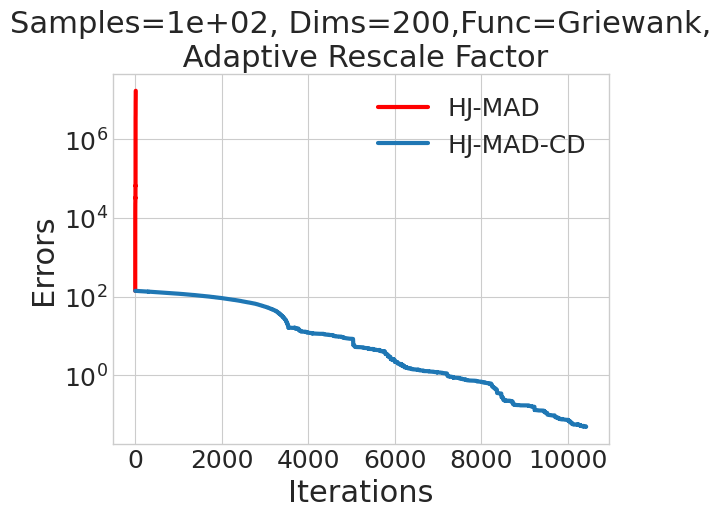

In [692]:
my_blue = '#1f77b4'
title_fontsize = 22
fontsize       = 18
fig1 = plt.figure()

plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.semilogy(xk_error_hist_MAD, color='red', linewidth=3)
ax.semilogy(xk_error_hist_cd, color=my_blue, linewidth=3);
# ax.semilogy(xk_error_hist_EGD[0:len(xk_error_hist_GD)], 'm-', linewidth=3)
#ax.semilogy(xk_error_hist_GD[0:len(xk_error_hist_GD)], 'g-', linewidth=3)
ax.set_title(f'Samples={int_samples:.0e}, Dims={dim},Func={f_name},\n Adaptive Rescale Factor', fontsize=title_fontsize)
ax.set_xlabel("Iterations", fontsize=title_fontsize)
ax.set_ylabel("Errors", fontsize=title_fontsize)
ax.legend(['HJ-MAD','HJ-MAD-CD', 'GD'],fontsize=fontsize)
# title_str = 'Relative Errors'
# ax.set_title(title_str, fontsize=title_fontsize)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'griewank_error_hist.png'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

In [693]:
# fig1 = plt.figure()

# plt.style.use('seaborn-whitegrid')
# ax = plt.axes()
# ax.semilogy(fk_hist_MAD, color='red', linewidth=3);
# ax.semilogy(fk_hist_MAD_cd, color=my_blue, linewidth=3);
# # ax.semilogy(fk_hist_EGD[0:len(xk_error_hist_GD)], 'm-', linewidth=3)
# ax.semilogy(fk_hist_GD[0:len(xk_error_hist_GD)], 'g-', linewidth=3)

# ax.set_xlabel("Iterations", fontsize=title_fontsize)
# ax.legend(['HJ-MAD','HJ-MAD-cd', 'GD'],fontsize=fontsize)
# # title_str = 'Objective Function Values'
# # ax.set_title(title_str, fontsize=title_fontsize)
# ax.tick_params(labelsize=fontsize, which='both', direction='in')

# save_str = 'griewank_func_hist.png'
# fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

In [694]:
# plt.figure()
# plt.subplot(2,2,1)
# plt.semilogy(xk_error_hist_MAD); plt.title('err hist')
# plt.semilogy(xk_error_hist_MAD_acc); plt.legend(['HJ-MAD','HJ-MAD-Accelerated'])
# plt.subplot(2,2,2)
# plt.semilogy(fk_hist_MAD); plt.title('fk hist')
# plt.semilogy(fk_hist_MAD_acc); plt.legend(['HJ-MAD','HJ-MAD-Accelerated'])
# plt.subplot(2,2,3)
# plt.semilogy(tk_hist_MAD); plt.title('tk hist')
# plt.semilogy(tk_hist_MAD_acc); plt.legend(['HJ-MAD','HJ-MAD-Accelerated'])
# plt.subplot(2,2,4)
# plt.semilogy(rel_grad_uk_norm_hist_MAD); plt.title('rel grad norm hist')
# plt.semilogy(rel_grad_uk_norm_hist_MAD_acc); plt.legend(['HJ-MAD','HJ-MAD-Accelerated'])
# plt.subplots_adjust(left=None, bottom=None, right=None, top=1.2, wspace=None, hspace=None)

### Save values

In [695]:
# filename = 'rel_errs_MAD.dat'
# with open(filename, 'w') as csv_file:
#   for idx, f_val in enumerate(xk_error_hist_MAD):
#     csv_file.write('%0.5e %0.5e\n' % (idx, f_val))

In [696]:
# filename = 'rel_errs_GD.dat'
# with open(filename, 'w') as csv_file:
#   for idx, f_val in enumerate(xk_error_hist_GD):
#     csv_file.write('%0.5e %0.5e\n' % (idx, f_val))

In [697]:
# filename = 'f_hist_MAD.dat'
# with open(filename, 'w') as csv_file:
#   for idx, f_val in enumerate(fk_hist_MAD):
#     csv_file.write('%0.5e %0.5e\n' % (idx, f_val))

In [698]:
# filename = 'f_hist_GD.dat'
# with open(filename, 'w') as csv_file:
#   for idx, f_val in enumerate(fk_hist_GD):
#     csv_file.write('%0.5e %0.5e\n' % (idx, f_val))

In [699]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import torch

from scipy import optimize

## Benchmark Functions

We also try some of scipy's global optimization algorithms on our test functions

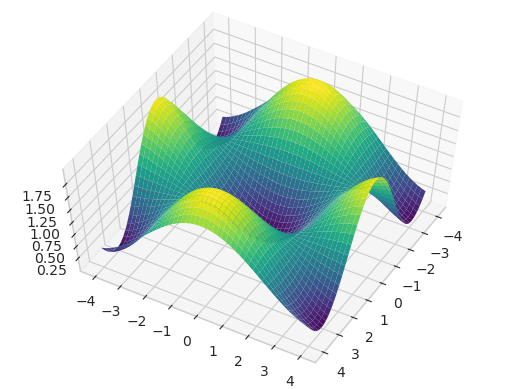

In [700]:
if dim >1:
  from mpl_toolkits.mplot3d import Axes3D

  ax_bry_3D_plot = 4
  surface_plot_resolution = 50
  x = np.linspace(-ax_bry_3D_plot, ax_bry_3D_plot, surface_plot_resolution)
  y = np.linspace(-ax_bry_3D_plot, ax_bry_3D_plot, surface_plot_resolution)

  X, Y = np.meshgrid(x, y)

  Z     = np.zeros(X.shape)
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      # convert to torch tensor and reshape to n_samples x n_features
      current_coordinate = torch.FloatTensor([X[i,j],Y[i,j]]).view(1, -1)
      Z[i,j] = f(current_coordinate)

  ax = plt.axes(projection='3d')
  ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                  cmap='viridis',
                  edgecolor='none')
  ax.view_init(60, 30) 

## Run Optimization Algorithms

In [701]:
# max_iter = int(5e4)
# basin_hopping_local_niter = int_samples # 100 iterations at each local minimization
# bounds = [(-20, 20), (-20, 20)]
# res_basin_hopping   = optimize.basinhopping(f_numpy, np.asarray(x0), niter=basin_hopping_local_niter)
# res_DE              = optimize.differential_evolution(f_numpy, bounds, maxiter=max_iter)
# res_dual_annealing  = optimize.dual_annealing(f_numpy, bounds, maxiter=max_iter)

In [702]:
# res_DE

In [703]:
# res_basin_hopping

In [704]:
# res_dual_annealing

In [705]:
# print('\n\n avg_func_evals = ', avg_func_evals)
# print(f"Average iterations before convergence: {average_iterations:.2f}")
# print(f"Average elapsed time: {sum_elapsed_time / avg_trials:.4f} seconds")